In [86]:
! pip install pyspark -q

In [87]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('Group 6 Final Project')\
    .getOrCreate()

There was no specific link to a CSV to download our data so we had to use the Kaggle API to download the ZIP file, unzip it, and store the data in a google drive folder to access for this project. Complete the pop-up to grant colab permission to access your google drive for this code to run properly.

In [88]:
import os
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive')

#Set Kaggle API credentials directly
os.environ['KAGGLE_USERNAME'] = "tylerkatz12345"
os.environ['KAGGLE_KEY'] = "78f266ea4970ea76b516c95e22278ace"

#Install kaggle
!pip install -q kaggle

file_path = '/content/drive/MyDrive/Group-6-project/marketing_campaign.csv'

# Only download/unzip if the file doesn't already exist
if not os.path.exists(file_path):

    # Create target folder
    !mkdir -p /content/drive/MyDrive/Group-6-project

    # Download dataset
    !kaggle datasets download -d imakash3011/customer-personality-analysis -p /content/drive/MyDrive/Group-6-project

    # Unzip dataset
    !unzip -q /content/drive/MyDrive/Group-6-project/customer-personality-analysis.zip -d /content/drive/MyDrive/Group-6-project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
customer_data = spark.read.option("sep", "\t").option("inferSchema", "true").csv("/content/drive/MyDrive/Group-6-project/marketing_campaign.csv", header = True)


In [90]:
customer_data.printSchema()
customer_data.show()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedC

In [91]:
#Gets number of rows in the dataset
row_count = customer_data.count()

print(row_count)

#2,240 rows in DF

2240


Data cleaning: After an initial inspection of the data, everything looked formatted correctly besides the DT_Customers variable which we will convert to a date time later. Besides that all we needed to do was drop rows with null values, and columns that we would not be using for our analysis.

In [92]:
from pyspark.sql import functions as F

#Showing the number of NA values in each column of the dataset
null_counts = customer_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in customer_data.columns])

null_counts.show()

+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
| ID|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+---

In [93]:
#Dropping rows with NA values in the Income column
customer_data = customer_data.na.drop(subset = ['Income'])

In [94]:
#Checking how many rows are in the dataset after dropping NA values
row_count = customer_data.count()

print(row_count)

2216


In [95]:
#Validating that there are no more NA values in the dataset
null_counts = customer_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in customer_data.columns])

null_counts.show()

+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
| ID|Year_Birth|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+---+----------+---------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+---

In [96]:
#Drops columns we won't be using for efficiency
customer_data_filtered = customer_data.drop('Z_CostContact', 'Z_Revenue', 'Response')

#Printing schema of filtered table to ensure necessary columns where dropped
customer_data_filtered.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedC

Feature engineering: Based on our initial analysis of the data, we wanted to feature engineer some new columns that would provide additional insight on each of the customers in our dataset. We also realized we needed to one hot encode the education and maritial status variables as they are categorical variables with no specific rank between them. However that step would be included later in the project during the preprocessing for the clustering pipeline.

In [97]:
##FEATURE ENGINEERING

#Creating the feature engineering dataframe which is a copy of the filtered dataframe
customer_data_fe = customer_data_filtered

#Creates total_num_kids column which combines the two kids columns to get the total number of kids
customer_data_fe = customer_data_fe.withColumn('total_num_kids',
                                                     F.col('Kidhome') + F.col('Teenhome')
                                                     )
#Converting Dt_Customer into a date value
customer_data_fe = customer_data_fe.withColumn('Dt_Customer_datetime',
                                                     F.to_date(F.col('Dt_Customer'), 'dd-MM-yyyy')
                                                     )

#Gets the maximum date from the Dt_Customer_datetime column
dt_max_date = customer_data_fe.select(F.max('Dt_Customer_datetime')).collect()[0][0]

#Creates the total_days_filtered which subtracts each dates from the maxiumum (most recent) date
customer_data_fe = customer_data_fe.withColumn('total_days_enlisted',
                                               F.date_diff(F.lit(dt_max_date), F.col('Dt_Customer_datetime'))
                                               )

#Creates the total_campaigns_accepted column which is a sum of AcceptedCmp1-5
customer_data_fe = customer_data_fe.withColumn('total_campaigns_accepted',
                                               F.col('AcceptedCmp1') + F.col('AcceptedCmp2') + F.col('AcceptedCmp3') + F.col('AcceptedCmp4') + F.col('AcceptedCmp5')
                                               )
#Extracts the year from the maximum date
max_year = dt_max_date.year

#Creates an age column that subtracts the maximum year from the Year_Birth
customer_data_fe = customer_data_fe.withColumn('age',
                                               F.lit(max_year) - F.col('Year_Birth')
                                               )


In [98]:
#5 different select statements to observe the feature engineered columns we created
customer_data_fe.select('Kidhome', 'Teenhome', 'total_num_kids').show()

customer_data_fe.select('Dt_Customer_datetime').show()

customer_data_fe.select('total_days_enlisted').show()

customer_data_fe.select('AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'total_campaigns_accepted').show()

customer_data_fe.select('Year_Birth', 'age').show()

+-------+--------+--------------+
|Kidhome|Teenhome|total_num_kids|
+-------+--------+--------------+
|      0|       0|             0|
|      1|       1|             2|
|      0|       0|             0|
|      1|       0|             1|
|      1|       0|             1|
|      0|       1|             1|
|      0|       1|             1|
|      1|       0|             1|
|      1|       0|             1|
|      1|       1|             2|
|      0|       0|             0|
|      0|       0|             0|
|      1|       1|             2|
|      0|       0|             0|
|      0|       0|             0|
|      1|       1|             2|
|      0|       0|             0|
|      0|       1|             1|
|      1|       0|             1|
|      0|       0|             0|
+-------+--------+--------------+
only showing top 20 rows

+--------------------+
|Dt_Customer_datetime|
+--------------------+
|          2012-09-04|
|          2014-03-08|
|          2013-08-21|
|          2014-02-1

In [99]:
customer_data_fe.show()

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------------+--------------------+-------------------+------------------------+---+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|total_num_kids|Dt_Customer_datetime|total_days_enlisted|total_campaigns_accepted|age|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+---------

In [100]:
#Analyze marital status before hot encoding

# Show count of each category in Marital_Status
customer_data_fe.groupBy("Marital_Status").count().orderBy("count", ascending=False).show()

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|       Married|  857|
|      Together|  573|
|        Single|  471|
|      Divorced|  232|
|         Widow|   76|
|         Alone|    3|
|          YOLO|    2|
|        Absurd|    2|
+--------------+-----+



We decided to change the Alone value in maritial status to single, which we felt better indicated a maritial status.

In [101]:
from pyspark.sql.functions import when
# Remove invalid categories
customer_data_fe = customer_data_fe.filter(~F.col("Marital_Status").isin("YOLO", "Absurd"))

# Replace 'Alone' with 'Single'
customer_data_fe = customer_data_fe.withColumn("Marital_Status",
    when(F.col("Marital_Status") == "Alone", "Single").otherwise(F.col("Marital_Status"))
)

#Verify the result
customer_data_fe.groupBy("Marital_Status").count().orderBy("count", ascending=False).show()


+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|       Married|  857|
|      Together|  573|
|        Single|  474|
|      Divorced|  232|
|         Widow|   76|
+--------------+-----+



In [102]:
#Analyze education before hot encoding

# Show count of each category in Education
customer_data_fe.groupBy("Education").count().orderBy("count", ascending=False).show()

+----------+-----+
| Education|count|
+----------+-----+
|Graduation| 1115|
|       PhD|  479|
|    Master|  364|
|  2n Cycle|  200|
|     Basic|   54|
+----------+-----+



In [103]:
#Change graduation to Bachelors and Basic to High School
customer_data_fe = customer_data_fe.withColumn(
    "Education",
    when(F.col("Education") == "Basic", "High School")
    .when(F.col("Education") == "Graduation", "Bachelors")
    .otherwise(F.col("Education"))
)

#Verify
customer_data_fe.groupBy("Education").count().orderBy("count", ascending=False).show()


+-----------+-----+
|  Education|count|
+-----------+-----+
|  Bachelors| 1115|
|        PhD|  479|
|     Master|  364|
|   2n Cycle|  200|
|High School|   54|
+-----------+-----+



Data exploration: After completing our data cleaning and feature engineer, we wanted to make some visualizations to get a better understanding of our data, and discover any interesting dynamics between variables.

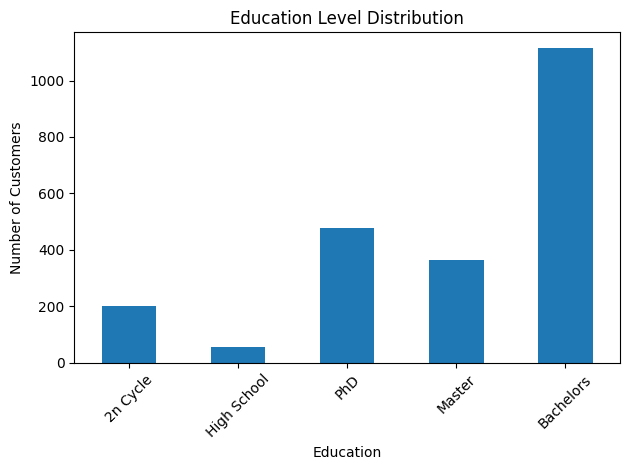

In [104]:
##EXPLORING DATA THROUGH VISUALIZATIONS
# Convert to pandas
edu_counts = customer_data_fe.groupBy("Education").count().toPandas()

# Plot
import matplotlib.pyplot as plt
edu_counts.plot(kind="bar", x="Education", y="count", legend=False)
plt.title("Education Level Distribution")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


During the exploratory process we realized that creating a total spent column would be beneficial for our analysis and clustering.

In [105]:
# Create total spent column for further analysis
cols = ["MntWines", "MntFruits", "MntMeatProducts",
        "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
customer_data_fe = customer_data_fe.withColumn("total_spent", sum([F.col(c) for c in cols]))

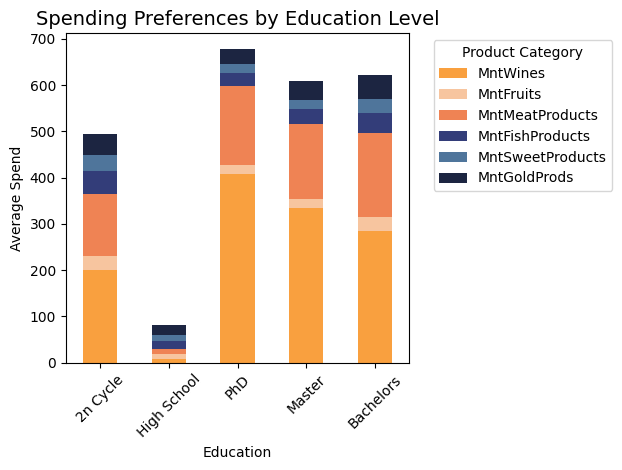

In [106]:
# Calculate average spend in each product category by education level

# Group by education and calculate average spend in each category
avg_spend_edu = customer_data_fe.groupBy("Education") \
    .agg(*[F.avg(c).alias(c) for c in cols]) \
    .toPandas().set_index("Education")

# Poster-themed color palette (orange/navy vibe)
colors = ['#F9A03F', '#F7C59F', '#EF8354', '#333D79', '#4F759B', '#1C2541']

# Plot stacked bar chart
avg_spend_edu.plot(kind="bar", stacked=True, color=colors)

# Styling
plt.title("Spending Preferences by Education Level", fontsize=14)
plt.ylabel("Average Spend")
plt.xticks(rotation=45)
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



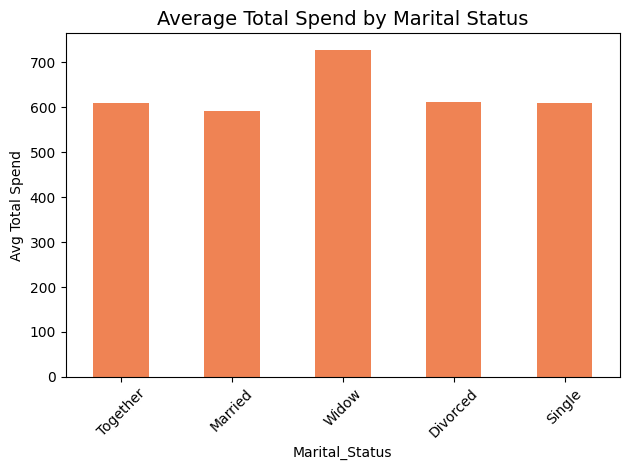

In [107]:
# Group and plot
spend_marital = customer_data_fe.groupBy("Marital_Status").agg(F.avg("total_spent").alias("Avg_Spend")).toPandas()

#Same theme
bar_color = '#EF8354'  # Matches previous palette, bold orange

spend_marital.plot(kind="bar", x="Marital_Status", y="Avg_Spend", legend=False, color=bar_color)

# Styling
plt.title("Average Total Spend by Marital Status", fontsize=14)
plt.ylabel("Avg Total Spend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



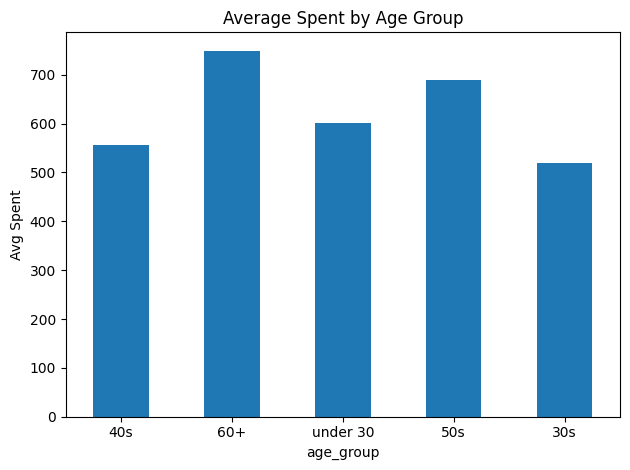

In [ ]:
# Create age groups
customer_data_fe = customer_data_fe.withColumn(
    "age_group",
    F.when(F.col("age") < 30, "under 30")
     .when(F.col("age") < 40, "30s")
     .when(F.col("age") < 50, "40s")
     .when(F.col("age") < 60, "50s")
     .otherwise("60+")
)

# Group by age_group and calculate average total_spent
spend_age = customer_data_fe.groupBy("age_group") \
    .agg(F.avg("total_spent").alias("avg_spent")).toPandas()

# Plot bar chart
spend_age.plot(kind="bar", x="age_group", y="avg_spent", legend=False)
plt.title("Average Spent by Age Group")
plt.ylabel("Avg Spent")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


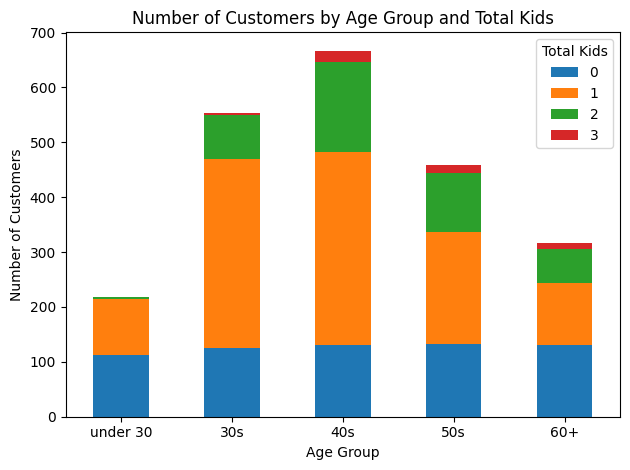

In [109]:
import pandas as pd
# Group by age_group and total_num_kids, then count
kids_dist = customer_data_fe.groupBy("age_group", "total_num_kids") \
    .count().toPandas()

# Sort age groups manually
order = ["under 30", "30s", "40s", "50s", "60+"]
kids_dist["age_group"] = pd.Categorical(kids_dist["age_group"], categories=order, ordered=True)
kids_dist = kids_dist.sort_values(["age_group", "total_num_kids"])

# Pivot for stacked bar chart
pivot = kids_dist.pivot(index="age_group", columns="total_num_kids", values="count").fillna(0)

# Plot
pivot.plot(kind="bar", stacked=True)
plt.title("Number of Customers by Age Group and Total Kids")
plt.xlabel("Age Group")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.legend(title="Total Kids")
plt.tight_layout()
plt.show()


<ipython-input-110-725979ce8719>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_spend_by_bin = enlist_spend.groupby("days_bin")["total_spent"].mean().reset_index()
<ipython-input-110-725979ce8719>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_spend_by_bin, x="days_bin", y="total_spent", palette="Blues_d")


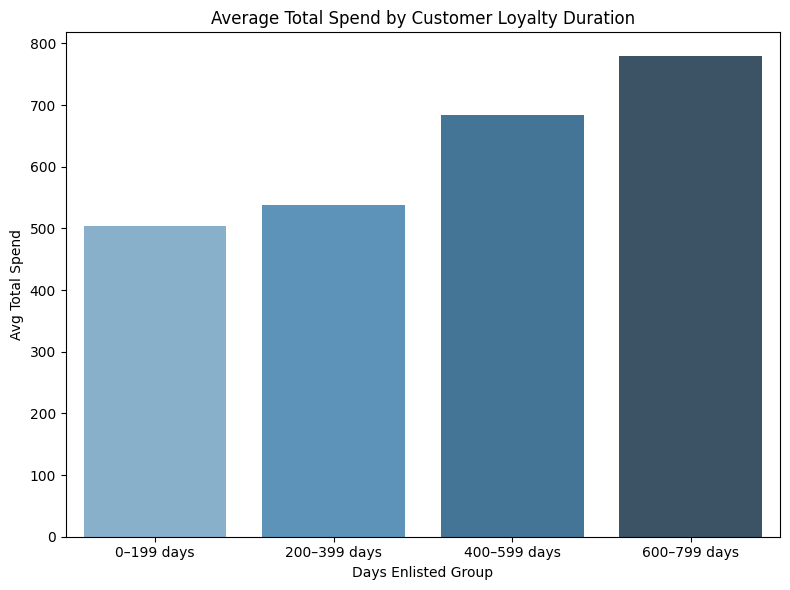

In [110]:
# Convert to pandas
enlist_spend = customer_data_fe.select("total_days_enlisted", "total_spent").toPandas()

# Define bin edges and matching labels (1 fewer label than number of edges)
bins = [0, 200, 400, 600, 800]
labels = ["0–199 days", "200–399 days", "400–599 days", "600–799 days"]

# Apply binning
enlist_spend["days_bin"] = pd.cut(enlist_spend["total_days_enlisted"], bins=bins, labels=labels, right=False)

# Group by bin and calculate average spend
avg_spend_by_bin = enlist_spend.groupby("days_bin")["total_spent"].mean().reset_index()

# Plot bar chart
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(data=avg_spend_by_bin, x="days_bin", y="total_spent", palette="Blues_d")
plt.title("Average Total Spend by Customer Loyalty Duration")
plt.xlabel("Days Enlisted Group")
plt.ylabel("Avg Total Spend")
plt.tight_layout()
plt.show()


In [111]:
#Verify new columns
customer_data_fe.show()

+----+----------+-----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------------+--------------------+-------------------+------------------------+---+-----------+---------+
|  ID|Year_Birth|  Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|total_num_kids|Dt_Customer_datetime|total_days_enlisted|total_campaigns_accepted|age|total_spent|age_group|
+----+----------+-----------+--------------+------+-------+--------+-----------+-------+--------+---------+-----------

Data preprocessing pipeline: After concluding our exploration of the data and gaining a better understanding for the customers represented within our data, it's now time to start working on our model. But first we needed to create a pipeline to select the features that would contribute to the clusters, standardize the numerical values, and one hot encode the categorical values mentioned before. We had to create a second vector assembler after conducting the standardization and one hot encoding, because we didn't want to standardizes the one hot encoded values as it would mess up the results for the categorization

In [112]:
##PREPROCESSING FOR K-MEANS CLUSTERING

from pyspark.ml import feature, clustering, Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#Creates vector of columns that need to be standardized
va = feature.VectorAssembler(inputCols= ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                                         'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Complain',
                                         'total_num_kids', 'total_days_enlisted', 'total_campaigns_accepted', 'age', 'total_spent'],
                             outputCol = 'init_features')

#Specifies how to standardize selected features
sc = feature.StandardScaler(withMean = True,
                           withStd = True,
                           inputCol = 'init_features',
                           outputCol = 'zfeatures')

# Convert categorical strings to indices
edu_indexer = StringIndexer(inputCol="Education", outputCol="Education_Index")
marital_indexer = StringIndexer(inputCol="Marital_Status", outputCol="Marital_Status_Index")

# One-hot encode the indexed columns
edu_encoder = OneHotEncoder(inputCol="Education_Index", outputCol="Education_OHE")
marital_encoder = OneHotEncoder(inputCol="Marital_Status_Index", outputCol="Marital_Status_OHE")

#Combines the standardized values with the OHE values into one features column
final_assembler = feature.VectorAssembler(
    inputCols= ['zfeatures', 'Education_OHE', 'Marital_Status_OHE'],
    outputCol= 'features'
)

#Builds a pipeline that standardizes the selected features
transformationPipe = Pipeline(stages = [va, sc, edu_indexer, marital_indexer, edu_encoder, marital_encoder, final_assembler])

#Fits and transforms the pipeline to a new data frame
customer_data_preproccessed = transformationPipe.fit(customer_data_fe).transform(customer_data_fe)

In [113]:
#Verify the pipeline worked succesfully
customer_data_preproccessed.show()

+----+----------+-----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------------+--------------------+-------------------+------------------------+---+-----------+---------+--------------------+--------------------+---------------+--------------------+-------------+------------------+--------------------+
|  ID|Year_Birth|  Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|total_num_kids|Dt_Customer_datetime|total_days_enlisted|total_campaigns_accepted|age|total_sp

Determining optimal K: Through our research we determined that we where going to use an elbow method graph to determine the optimal number of K clusters would be for this data set. However, PySPark doesn't have a natively built in elbow method function so we had to do this manually by using a loop iterating through values 2-10, performing a K-Means clustering for each value using the value as the K, and saving the K value with it's correlated WSSSE value in a dataframe. Since this code is running multiple clustering models, it take a little while to run.

In [114]:
##MANUALLY CREATING ELBOW METHOD & TESTING DIFFERENT K VALUE SILHOUTTE SCORES

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#Creating empty list to store values in later
cost = []

#Runs KMeans clustering with K values of 2-10 and stores them along with the wssse for each model. This represents a measure of how compact clusters are
for k in range(2, 11):
  kmeans = KMeans(featuresCol= 'features', k = k, seed = 1)
  model = kmeans.fit(customer_data_preproccessed)
  wssse = model.summary.trainingCost
  cost.append((k, wssse))

In [115]:
#Converting list created to a dataframe with two columns and inspecting the output
cost_df = spark.createDataFrame(cost, ['k', 'wssse'])
cost_df.show()

+---+------------------+
|  k|             wssse|
+---+------------------+
|  2| 31002.97414854272|
|  3| 28178.02946776301|
|  4|26853.878971097565|
|  5|  24736.9070699504|
|  6|23921.640253083995|
|  7|24696.746862163858|
|  8|24000.707224543145|
|  9|23662.388680226486|
| 10|22778.464521566646|
+---+------------------+



Text(0, 0.5, 'WSSSE')

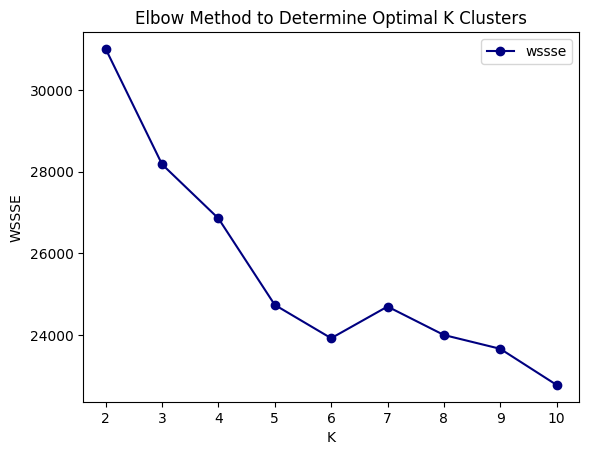

In [116]:
#Converting cost df to pandas and graphing the K and wssse values to make an elbow graph
cost_pd = cost_df.toPandas()
ax = cost_pd.plot(x = 'k',
             y = 'wssse',
             kind = 'line',
             marker = 'o',
             color = 'navy',
             title = 'Elbow Method to Determine Optimal K Clusters')

ax.set_xlabel('K')
ax.set_ylabel('WSSSE')

In [117]:
#Creates a Kmeans clustering with 3 groups
kmeans_3 = KMeans(featuresCol = 'features', k = 3, seed = 1)
model_3 = kmeans_3.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 4 groups
kmeans_4 = KMeans(featuresCol = 'features', k = 4, seed = 1)
model_4 = kmeans_4.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 5 groups
kmeans_5 = KMeans(featuresCol = 'features', k = 5, seed = 1)
model_5 = kmeans_5.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 6 groups
kmeans_6 = KMeans(featuresCol = 'features', k = 6, seed = 1)
model_6 = kmeans_6.fit(customer_data_preproccessed)

#Creates a Kmeans clustering with 7 groups
kmeans_7 = KMeans(featuresCol = 'features', k = 7, seed = 1)
model_7 = kmeans_7.fit(customer_data_preproccessed)

#Makes predictions on which group each customer belongs to based on the two different models
predictions_3 = model_3.transform(customer_data_preproccessed)
predictions_4 = model_4.transform(customer_data_preproccessed)
predictions_5 = model_5.transform(customer_data_preproccessed)
predictions_6 = model_6.transform(customer_data_preproccessed)
predictions_7 = model_7.transform(customer_data_preproccessed)


In [118]:
#Defines evaluator to specify to calculate silhoutte scores
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

#Applies evaliators to each model
silhouette_3 = evaluator.evaluate(predictions_3)
silhouette_4 = evaluator.evaluate(predictions_4)
silhouette_5 = evaluator.evaluate(predictions_5)
silhouette_6 = evaluator.evaluate(predictions_6)
silhouette_7 = evaluator.evaluate(predictions_7)

#Prints silhoutte scores
print(f"Silhouette score for k=3: {silhouette_3}")
print(f"Silhouette score for k=4: {silhouette_4}")
print(f"Silhouette score for k=5: {silhouette_5}")
print(f"Silhouette score for k=6: {silhouette_6}")
print(f"Silhouette score for k=7: {silhouette_7}")

#Based on the output of the silhoutte scores I believe K = 5 is the more optimal model

Silhouette score for k=3: 0.3135884735606854
Silhouette score for k=4: 0.2996744918515069
Silhouette score for k=5: 0.32107670876038386
Silhouette score for k=6: 0.1642402769343988
Silhouette score for k=7: 0.12108222289073371


In [119]:
#Displaying how many customers are in each group
predictions_3.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1045|
|         2|  558|
|         0|  609|
+----------+-----+



Clustering vizualization: Based on the elbow method and silhoutte scores we initially decided to use a K value of 5, but after observing the visualizations of the clusters using PCA, the results didn't make a lot of sense. We then decided to use a K of three as it had the second highest silhoutte score and the clusters visually made sense. Displayed the visualizations for 3 and 5 clusters

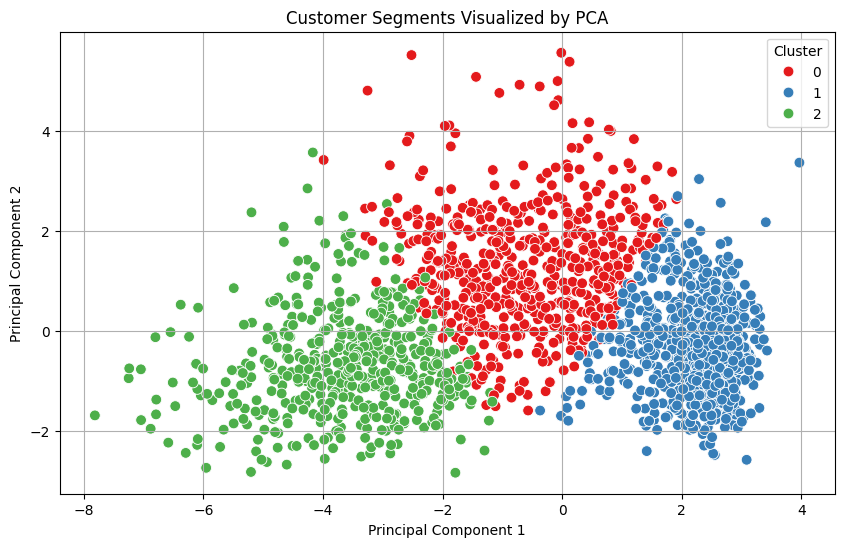

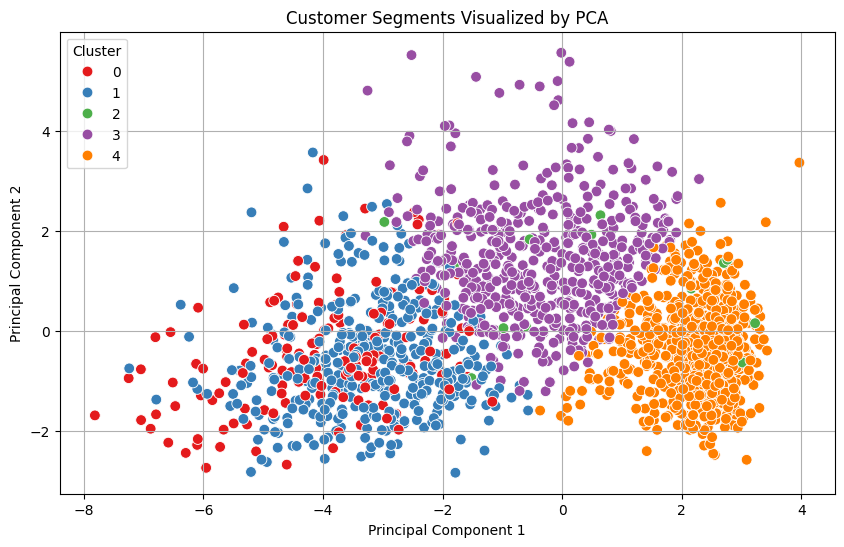

In [120]:
##VISUALIZING CLUSTERS WITH PCA

from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#Specifying 2 pca components, fitting and training the PCA model
pca = PCA(k = 2, inputCol = 'features', outputCol = 'pca_features')
pca_model = pca.fit(predictions_3)
pca_result = pca_model.transform(predictions_3)

#Select only the PCA features and cluster prediction
pca_df = pca_result.select("pca_features", "prediction")

#Convert each pca component to its own column for graphing, convering to pandas
pca_pd = pca_df.rdd.map(lambda row: (
    float(row["pca_features"][0]),
    float(row["pca_features"][1]),
    row["prediction"]
)).toDF(["pca1", "pca2", "prediction"]).toPandas()

# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot using seaborn on the given axes
sns.scatterplot(data=pca_pd, x="pca1", y="pca2", hue="prediction", palette="Set1", s=60, ax=ax)

# Customize
ax.set_title("Customer Segments Visualized by PCA")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(title="Cluster")
ax.grid(True)

#Specifying 2 pca components, fitting and training the PCA model
pca2 = PCA(k = 2, inputCol = 'features', outputCol = 'pca_features')
pca_model2 = pca.fit(predictions_5)
pca_result2 = pca_model.transform(predictions_5)

#Select only the PCA features and cluster prediction
pca_df2 = pca_result2.select("pca_features", "prediction")

#Convert each pca component to its own column for graphing, convering to pandas
pca_pd2 = pca_df2.rdd.map(lambda row: (
    float(row["pca_features"][0]),
    float(row["pca_features"][1]),
    row["prediction"]
)).toDF(["pca1", "pca2", "prediction"]).toPandas()

# Create a new figure and axes object
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Plot using seaborn on the given axes
sns.scatterplot(data=pca_pd2, x="pca1", y="pca2", hue="prediction", palette="Set1", s=60, ax=ax1)

# Customize
ax1.set_title("Customer Segments Visualized by PCA")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.legend(title="Cluster")
ax1.grid(True)


Determining cluster profiles: After creating the clusters, we wanted to build a charaterstic profile on each of the groups to better understand the reasoning for the clustering, which helped us produce actionable insight on our data.

In [121]:
##ANALYZING THE DIFFERENT GROUPS CREATED

from pyspark.sql.functions import avg, round as rnd

#Getting average of different variables to build a persona for each group
cluster_profile = predictions_3.groupBy("prediction").agg(
    rnd(avg("income"), 2).alias("avg_income"),
    rnd(avg("age"), 2).alias("avg_age"),
    rnd(avg("total_num_kids"), 2).alias("avg_num_kids"),
    rnd(avg("Recency"), 2).alias("avg_recency"),
    rnd(avg("MntWines"), 2).alias("avg_wine_spend"),
    rnd(avg("MntFruits"), 2).alias("avg_fruit_spend"),
    rnd(avg("MntMeatProducts"), 2).alias("avg_meat_spend"),
    rnd(avg("MntFishProducts"), 2).alias("avg_fish_spend"),
    rnd(avg("MntSweetProducts"), 2).alias("avg_sweet_spend"),
    rnd(avg("MntGoldProds"), 2).alias("avg_gold_spend"),
    rnd(avg("total_spent"), 2).alias("avg_total_spend"),
    rnd(avg("NumWebPurchases"), 2).alias("avg_web_purchases"),
    rnd(avg("NumStorePurchases"), 2).alias("avg_store_purchases"),
    rnd(avg("NumDealsPurchases"), 2).alias("avg_deal_use"),
    rnd(avg("total_campaigns_accepted"), 2).alias("avg_campaign_accepts")
)

#Pivots the education values to get numbers per category to add to cluster profiles
education_pivot = predictions_3.groupBy("prediction").pivot("Education").count().na.fill(0)

#Pivots the maritial status values to get number per category to add to cluster profiles
marital_pivot = predictions_3.groupBy("prediction").pivot("Marital_Status").count().na.fill(0)

#First joins the education pivot table to the cluster profiles, then the maritial status pivot table
profile_with_edu = cluster_profile.join(education_pivot, on="prediction", how="left")
full_cluster_profile = profile_with_edu.join(marital_pivot, on="prediction", how="left")

full_cluster_profile.orderBy('prediction').show(truncate = False)

+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|prediction|avg_income|avg_age|avg_num_kids|avg_recency|avg_wine_spend|avg_fruit_spend|avg_meat_spend|avg_fish_spend|avg_sweet_spend|avg_gold_spend|avg_total_spend|avg_web_purchases|avg_store_purchases|avg_deal_use|avg_campaign_accepts|2n Cycle|Bachelors|High School|Master|PhD|Divorced|Married|Single|Together|Widow|
+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|0         |57993.3   |48.83  |1.13        |48

Recommendation algorithms: After creating our clusters, we knew we wanted to make some sort of recommendation algorithm to recommend specific items, and deals to each customer to provide the store with insight on customers that would allow for effetive targeted marketing and inventory managment. We first attempted to model our recommendation system off the one we did in class, but it didn't make much sense for what we where trying to achieve. After brainstorming, discussing, and bouncing ideas off ChatGPT we decided to create three different recommendation algorithms to achieve our goal:

1. Association Rules Mining (FPGrowth)- Based on a project we did in another class we where inspired to use Association Rules Mining to discover relationshipts between product selection, which would allow the store to identify what groups where likely to buy which products and why. After researching online we found that this was able to be achieved through the FPGrowth model in the pyspark.ml.fpm module. This gives the store insight on items they should keep in higher stock if they're often bought in addition to other items.

2. Hybrid recommendation algorithm- This recommendation system determined the favorite (most purchased) items in each group, then for each customer their individual spending history was subtracted from their group favorites, if there was an item that was in their groups favorites that they hadn't bought it would recommend that item to the customer. And in the event that the customer had already bought all their groups favorite items, we advised that the store should recommend trying new varieties of their groups favorites. This will allow the store to make specifically target emails, advertisements, and ad campaigns to each customer.

3. Deal recommendation algorithm- For this algorithm, we where unable to come up with a computational approach to this since deals are words and it would be difficult or impossible to create a model to reach our intended goal. So based on the group characteristics derived above, and research on what grocery stores have offered in the past, we where able to come up with a hard coded algorithm that recommends a specific deal to each group based on their demographics and spending habits.

In [122]:
##ASSOCIATION RULES MINING
from pyspark.sql.functions import array, lit, when, col, expr, array_contains
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import explode, size
from functools import reduce
from pyspark.sql import DataFrame

# Build a raw items array
customer_basket_raw = customer_data_preproccessed.withColumn(
    "raw_items", array(
        when(col("MntWines") > 0, lit("Wines")),
        when(col("MntFruits") > 0, lit("Fruits")),
        when(col("MntMeatProducts") > 0, lit("Meat")),
        when(col("MntFishProducts") > 0, lit("Fish")),
        when(col("MntSweetProducts") > 0, lit("Sweets")),
        when(col("MntGoldProds") > 0, lit("Gold"))
    )
)

#Filters out nulls from the array
customer_basket = customer_basket_raw.withColumn(
    "items",
    expr("filter(raw_items, x -> x IS NOT NULL)")
).drop("raw_items")

#Defines and fits an FPGrowth (Assocation rules) model
fp_growth = FPGrowth(itemsCol="items", minSupport=0.005, minConfidence=0.6)
fp_model = fp_growth.fit(customer_basket)

product_cols = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]


# Add items column with nulls filtered out
customer_clustered = predictions_3.withColumn(
    "raw_items", array(
        when(col("MntWines") > 0, lit("Wines")),
        when(col("MntFruits") > 0, lit("Fruits")),
        when(col("MntMeatProducts") > 0, lit("Meat")),
        when(col("MntFishProducts") > 0, lit("Fish")),
        when(col("MntSweetProducts") > 0, lit("Sweets")),
        when(col("MntGoldProds") > 0, lit("Gold"))
    )
).withColumn("items", expr("filter(raw_items, x -> x IS NOT NULL)")).drop("raw_items")


# Create a lookup of customer and clusters
cluster_lookup = customer_clustered.select("ID", "items", "prediction")

# Explode item arrays for joining if needed
# Get association rules from model
rules_df = fp_model.associationRules
rules_df.show(truncate=False)

def get_top_rules_per_cluster_fp(customer_clustered_df, top_k_rules=3, min_support=0.005, min_confidence=0.3):

    #Gets the cluster ID's
    cluster_ids = [row['prediction'] for row in customer_clustered_df.select("prediction").distinct().collect()]
    top_rules_by_cluster = []

    for cluster_id in cluster_ids:
        # Filter data to one cluster and drop prediction to avoid FP-Growth conflict
        cluster_df = customer_clustered_df.filter(col("prediction") == cluster_id).drop("prediction")

        # Fit FP-Growth only on this cluster
        fp = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
        model = fp.fit(cluster_df)

        # Get top rules
        rules = model.associationRules.orderBy(
                    #col("lift").desc(),
                    #col("support").desc(),
                    col("confidence").desc()
                ).limit(top_k_rules)
        rules = rules.withColumn("cluster", lit(cluster_id))

        #Adds result to list
        top_rules_by_cluster.append(rules)

    if top_rules_by_cluster:
        final_rules_df = reduce(DataFrame.unionByName, top_rules_by_cluster)
        return final_rules_df.select("cluster", "antecedent", "consequent", "support", "confidence", "lift")
    else:
        return None

top_rules_df = get_top_rules_per_cluster_fp(customer_clustered, top_k_rules=5)

top_rules_df.show(truncate=False)

+---------------------+----------+------------------+------------------+------------------+
|antecedent           |consequent|confidence        |lift              |support           |
+---------------------+----------+------------------+------------------+------------------+
|[Sweets, Gold, Wines]|[Meat]    |1.0               |1.0004522840343735|0.7929475587703436|
|[Sweets, Gold, Wines]|[Fruits]  |0.8962371721778791|1.0910713400426355|0.7106690777576854|
|[Sweets, Gold, Wines]|[Fish]    |0.9013683010262258|1.0877395973104262|0.7147377938517179|
|[Fish]               |[Sweets]  |0.8854337152209493|1.0880996544826333|0.7337251356238698|
|[Fish]               |[Fruits]  |0.8881614839061648|1.0812400673640268|0.7359855334538878|
|[Fish]               |[Gold]    |0.9787234042553191|1.0064789261798075|0.8110307414104883|
|[Fish]               |[Wines]   |0.9929078014184397|0.9987776519952654|0.8227848101265823|
|[Fish]               |[Meat]    |0.9994544462629569|0.9999064835520852|0.828209

In [123]:
##HYBRID RECOMMENDATION ALGORITHM BASED ON CLUSTER PREFERENCES AND INDIVIDUAL PURCHASING HISTORY

from pyspark.sql.functions import explode, count, row_number, col, array_except, size, lit, array, collect_list
from pyspark.sql.window import Window

def recommend_for_all_customers(customer_clustered_df, top_n=5):

    #Explode items to get product popularity per cluster
    exploded = customer_clustered_df.withColumn("product", explode("items"))

    #Get top N products per cluster
    product_counts = exploded.groupBy("prediction", "product").agg(count("*").alias("purchase_count"))

    #Creates window specification to perform calculations on group
    windowSpec = Window.partitionBy("prediction").orderBy(col("purchase_count").desc())

    #Ranks product recomendations
    ranked = product_counts.withColumn("rank", row_number().over(windowSpec))
    top_cluster_products = ranked.filter(col("rank") <= top_n)

    #Aggregate top products per cluster into array
    cluster_top_products = top_cluster_products.groupBy("prediction") \
        .agg(collect_list("product").alias("cluster_top_products"))

    #Join with original customer data
    customers_with_cluster_top = customer_clustered_df.join(cluster_top_products, on="prediction", how="left")

    #Calculate recommendations
    with_recommendations = customers_with_cluster_top.withColumn(
        "recommendations",
        array_except("cluster_top_products", "items")
    )

    #Add fallback logic
    from pyspark.sql.functions import when

    #If the customer has already bought all products recomended to their group, reminds them of the products they like that they have already bought
    final_df = with_recommendations.withColumn(
        "fallback_recommendations",
        when(size(col("recommendations")) == 0, col("cluster_top_products")).otherwise(array())
    ).withColumn(
        "reason",
        when(size(col("recommendations")) == 0, lit("Reminder: These are favorites in your segment"))
        .when(size(col("recommendations")) < top_n, lit("Popular in your segment you haven't tried yet"))
        .otherwise(lit("Top products in your segment you haven't bought yet"))
    )

    return final_df.select("ID", "prediction", "items", "recommendations", "fallback_recommendations", "reason")


In [124]:
all_recommendations_df = recommend_for_all_customers(customer_clustered, top_n=5)
all_recommendations_df.show(truncate=False)

+----+----------+-----------------------------------------+---------------+---------------------------------+---------------------------------------------+
|ID  |prediction|items                                    |recommendations|fallback_recommendations         |reason                                       |
+----+----------+-----------------------------------------+---------------+---------------------------------+---------------------------------------------+
|5524|2         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Wines, Meat, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|2174|1         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Meat, Wines, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|4141|0         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]             |[Wines, Meat, Gold, Fish, Fruits]|Reminder: These are favorites in your segment|
|6182|1         |[Wines, Fruits, Meat, Fish, Sweets, Gold]|[]   

In [125]:
##HARD CODED DEAL RECOMENDATION ALGORITHM

#Hardcoded these values by observing the data and some input from ChatGPT
def persona_product_recommender(df):
    return df.withColumn(
        "recommended_products",
        when(col("prediction") == 0, "Wines, Meat, Gold")
        .when(col("prediction") == 1, "Sweet Products, Meat")
        .when(col("prediction") == 2, "Wines, Fish, Gold")
    ).withColumn(
        "deal_offer_type",
        when(col("prediction") == 0, "Online bundle or BOGO deal")
        .when(col("prediction") == 1, "In-store coupons and family packs")
        .when(col("prediction") == 2, "Loyalty rewards & email promos")
    ).withColumn(
        "deal_persona_summary",
        when(col("prediction") == 0, "Balanced mid-spender with deal interest — engage online")
        .when(col("prediction") == 1, "Price-sensitive shopper — in-store incentives work best")
        .when(col("prediction") == 2, "High-income loyalist — reward with exclusivity and quality")
    )

In [126]:
from pyspark.sql.functions import first

personalized_deals_df = persona_product_recommender(predictions_3)

personalized_deals_df = personalized_deals_df.groupBy("prediction").agg(
    first("recommended_products").alias("recommended_products"),
    first("deal_offer_type").alias("deal_offer_type"),
    first("deal_persona_summary").alias("deal_persona_summary")
).orderBy("prediction")

personalized_deals_df.show(truncate=False)

+----------+--------------------+---------------------------------+----------------------------------------------------------+
|prediction|recommended_products|deal_offer_type                  |deal_persona_summary                                      |
+----------+--------------------+---------------------------------+----------------------------------------------------------+
|0         |Wines, Meat, Gold   |Online bundle or BOGO deal       |Balanced mid-spender with deal interest — engage online   |
|1         |Sweet Products, Meat|In-store coupons and family packs|Price-sensitive shopper — in-store incentives work best   |
|2         |Wines, Fish, Gold   |Loyalty rewards & email promos   |High-income loyalist — reward with exclusivity and quality|
+----------+--------------------+---------------------------------+----------------------------------------------------------+



Final product: In this final code block, we combined all the results of this project: the PCA cluster visualization, characteristics of each cluster, and our three recomendation algorithms providing a culmination of all the elements we created throughout this project.

+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|prediction|avg_income|avg_age|avg_num_kids|avg_recency|avg_wine_spend|avg_fruit_spend|avg_meat_spend|avg_fish_spend|avg_sweet_spend|avg_gold_spend|avg_total_spend|avg_web_purchases|avg_store_purchases|avg_deal_use|avg_campaign_accepts|2n Cycle|Bachelors|High School|Master|PhD|Divorced|Married|Single|Together|Widow|
+----------+----------+-------+------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+------------+--------------------+--------+---------+-----------+------+---+--------+-------+------+--------+-----+
|0         |57993.3   |48.83  |1.13        |48

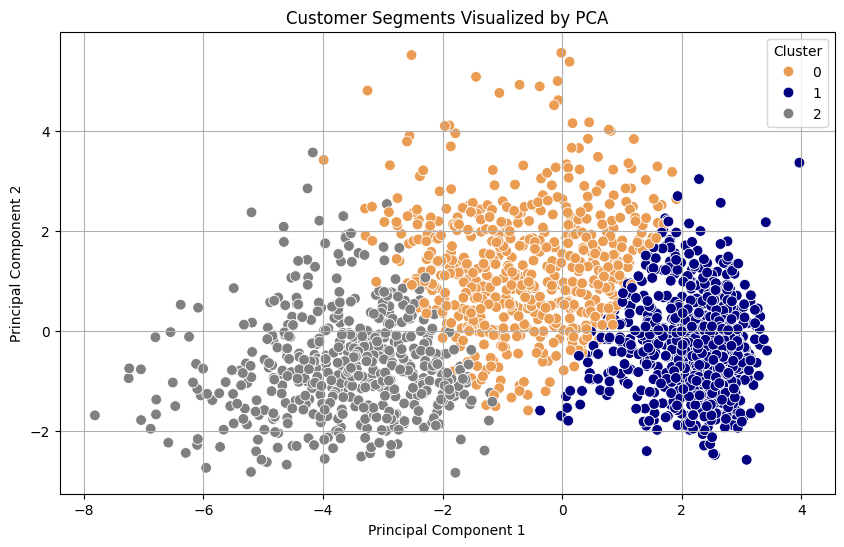

In [127]:
##FINAL OUTPUTS FOR ANALYSIS

#Creating color pallete for clusters to match the poster
custom_palette = {0: "#ea9c53", 1: "navy", 2: "gray"}

# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot using seaborn on the given axes
sns.scatterplot(data=pca_pd, x="pca1", y="pca2", hue="prediction", palette=custom_palette, s=60, ax=ax)

# Customize
ax.set_title("Customer Segments Visualized by PCA")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(title="Cluster")
ax.grid(True)

#Analysis of each group
full_cluster_profile.orderBy('prediction').show(truncate = False)

#Assocation rules
top_rules_df.show(truncate=False)

#Recomendations based on cluster preferences and individual history
all_recommendations_df.show(truncate=False)

non_empty_recommendations = all_recommendations_df.filter(size(col("recommendations")) > 0)
non_empty_recommendations.show(truncate=False)

#Deal recomendations for each group
personalized_deals_df.show(truncate=False)